In [194]:
%load_ext autoreload
%autoreload 2
%pylab inline

The autoreload extension is already loaded. To reload it, use:
  %reload_ext autoreload
Populating the interactive namespace from numpy and matplotlib


/home/nati/.virtualenvs/gpu/lib/python3.5/site-packages/IPython/core/magics/pylab.py:160: UserWarning: pylab import has clobbered these variables: ['plot', 'f']
`%matplotlib` prevents importing * from pylab and numpy
  "\n`%matplotlib` prevents importing * from pylab and numpy"


In [195]:
import numpy as np
import tensorflow as tf
import os, sys, time
os.environ["CUDA_VISIBLE_DEVICES"]=""
import utils, optimization, metrics, plot

# Parameters

In [207]:
spix = 256
path = '../data/size{}_splits1000_n500x3/'.format(spix)
input_pattern = 'Box_70*snapshot_050'
file_ext = '.dat'
k = 10

# Data handling

Load the data

In [55]:
queue = []
for file in os.listdir(path):
    if file.endswith(file_ext) and (np.all([x in file for x in input_pattern.split("*")])):
        queue.append(os.path.join(path, file))
nsamples = len(queue)
print('They are {} "{}" files.'.format(nsamples, file_ext))      

They are 15000 ".dat" files.


In [151]:
nsamples = 1000
input_img = np.vstack(map(lambda i:np.fromfile(queue[i], dtype=float32), range(nsamples)))
input_img.resize([nsamples,spix,spix])


In [152]:
input_img = utils.forward_map(input_img,k)

# input_img = np.log(input_img+0.001)

# p = np.random.permutation(nsamples)
# input_img = input_img[p,]

Let us make small patches of 64 :-)

# A) Load the model

In [239]:
import pickle
from model import *
from gan import *

try:
    del(params)
    del(obj)
except:
    pass

checkpoints = None


# pathgan = '../../saved_result/WGAN64_2018_1_14_19_28checkpoints/'
# checkpoints = '12000'
# ns = 64


# pathgan = '../../saved_result/WGAN128_2018_1_14_21_8checkpoints/'
# checkpoints = '12600'
# ns = 128

pathgan = '../../saved_result/WGAN256_2018_1_13_14_25checkpoints/'
checkpoints = '15000'
ns = 256


cut = spix//ns
img_small = np.zeros([nsamples*cut*cut, ns, ns])
for i in range(cut):
    for j in range(cut):
        l = j + i*cut 
        img_small[l*nsamples:(l+1)*nsamples,:,:] = input_img[:,i*ns:(i+1)*ns,j*ns:(j+1)*ns]


with open(pathgan+'params.pkl', 'rb') as f:
    params = pickle.load(f)
obj = GAN(params)


Generator 
------------------------------------------------------------
     The input is of size (?, 100)
     0 Full layer with 2048 outputs
         Size of the variables: (?, 2048)
     Reshape to (?, 8, 8, 32)
     1 Deconv layer with 32 channels
         Batch norm
         Size of the variables: (?, 16, 16, 32)
     2 Deconv layer with 64 channels
         Batch norm
         Size of the variables: (?, 32, 32, 64)
     3 Deconv layer with 128 channels
         Batch norm
         Size of the variables: (?, 64, 64, 128)
     4 Deconv layer with 256 channels
         Batch norm
         Size of the variables: (?, 128, 128, 256)
     5 Deconv layer with 128 channels
         Batch norm
         Size of the variables: (?, 256, 256, 128)
     6 Deconv layer with 1 channels
         Size of the variables: (?, 256, 256, 1)
    Non lienarity: tanh
     The output is of size (?, 256, 256, 1)
------------------------------------------------------------

Discriminator 
--------------------

# Generate some samples

In [240]:
N = 500


if checkpoints is None:
    gen_sample, gen_sample_raw = obj.generate(N=N)
else:
    file_name = pathgan+obj.model_name+'-'+checkpoints
    
    gen_sample, gen_sample_raw = obj.generate(N=N, file_name=file_name)

gen_sample = np.squeeze(gen_sample)
gen_sample_raw = np.squeeze(gen_sample_raw)
real_sample_raw = utils.backward_map(img_small[:N],k=k)

 [*] Reading checkpoints...
INFO:tensorflow:Restoring parameters from ../../saved_result/WGAN256_2018_1_13_14_25checkpoints/WGAN256-15000


Print a few samples

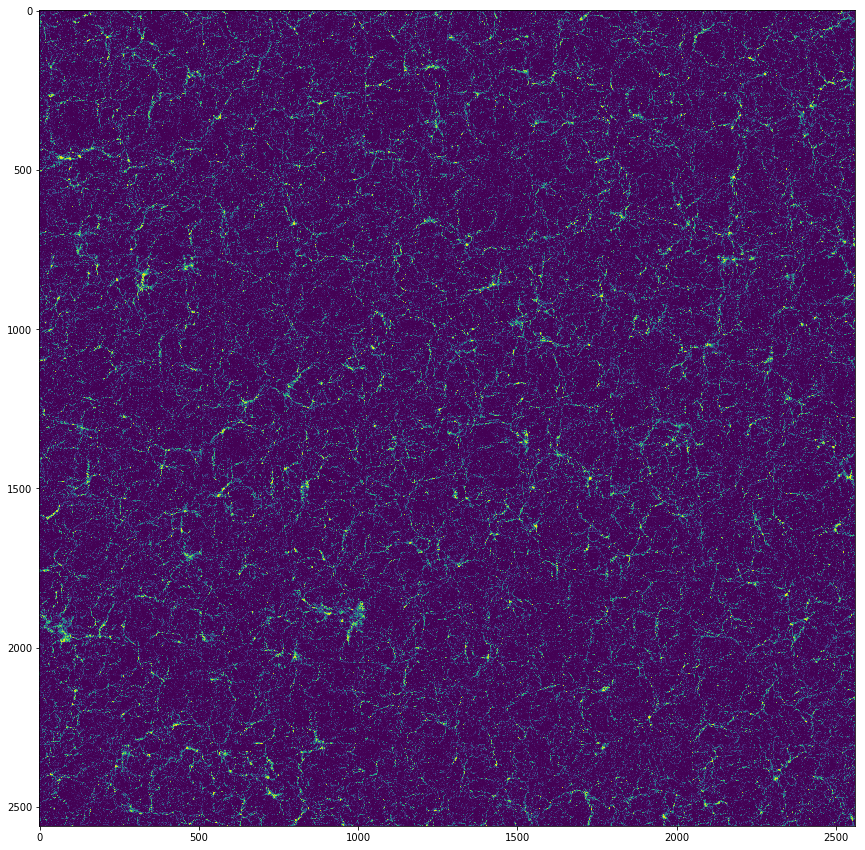

In [241]:
plt.figure(figsize=(15,15))
utils.draw_images(gen_sample,nx=10,ny=10,px=ns,py=ns)

# Evaluate the model

In [242]:
psd_gen, x = metrics.power_spectrum_batch_phys(X1=gen_sample_raw)
psd_real, x = metrics.power_spectrum_batch_phys(X1=real_sample_raw)


def psd_metric(gen_sample_raw, real_sample_raw):
    psd_gen, _ = metrics.power_spectrum_batch_phys(X1=gen_sample_raw)
    psd_real, _ = metrics.power_spectrum_batch_phys(X1=real_sample_raw)
    psd_gen = np.mean(psd_gen, axis=0)    
    psd_real = np.mean(psd_real, axis=0)
    e = psd_real - psd_gen
    l2 = np.mean(e*e)
    loge = 10*(log10(psd_real+1e-5) - log10(psd_gen+1e-5))
    logel2 = np.mean(loge*loge)
    return l2, logel2
l2, logel2 = psd_metric(gen_sample_raw, real_sample_raw)


In [243]:
print('Log PSD loss: {}\n L2 PSD loss: {}'.format(logel2, l2))

Log PSD loss: 0.6356210232254993
 L2 PSD loss: 1761.0893017506771


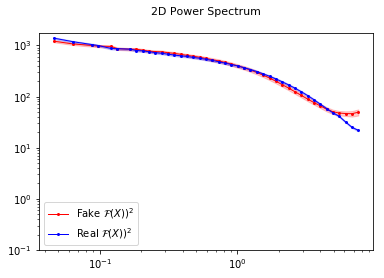

In [244]:
fig = plt.Figure()
ax = plt.gca()
ax.set_xscale("log")
ax.set_yscale("log")
linestyle = {"linewidth": 1, "markeredgewidth": 0, "markersize": 3, "marker": "o", "linestyle": "-"}

plot.plot_with_shade(ax, x, psd_gen, color='r', label="Fake $\mathcal{F}(X))^2$", **linestyle)
plot.plot_with_shade(ax, x, psd_real, color='b', label="Real $\mathcal{F}(X))^2$", **linestyle)
ax.set_ylim(bottom=0.1)
ax.title.set_text("2D Power Spectrum\n")
ax.title.set_fontsize(11)
ax.tick_params(axis='both', which='major', labelsize=10)
_ = ax.legend()


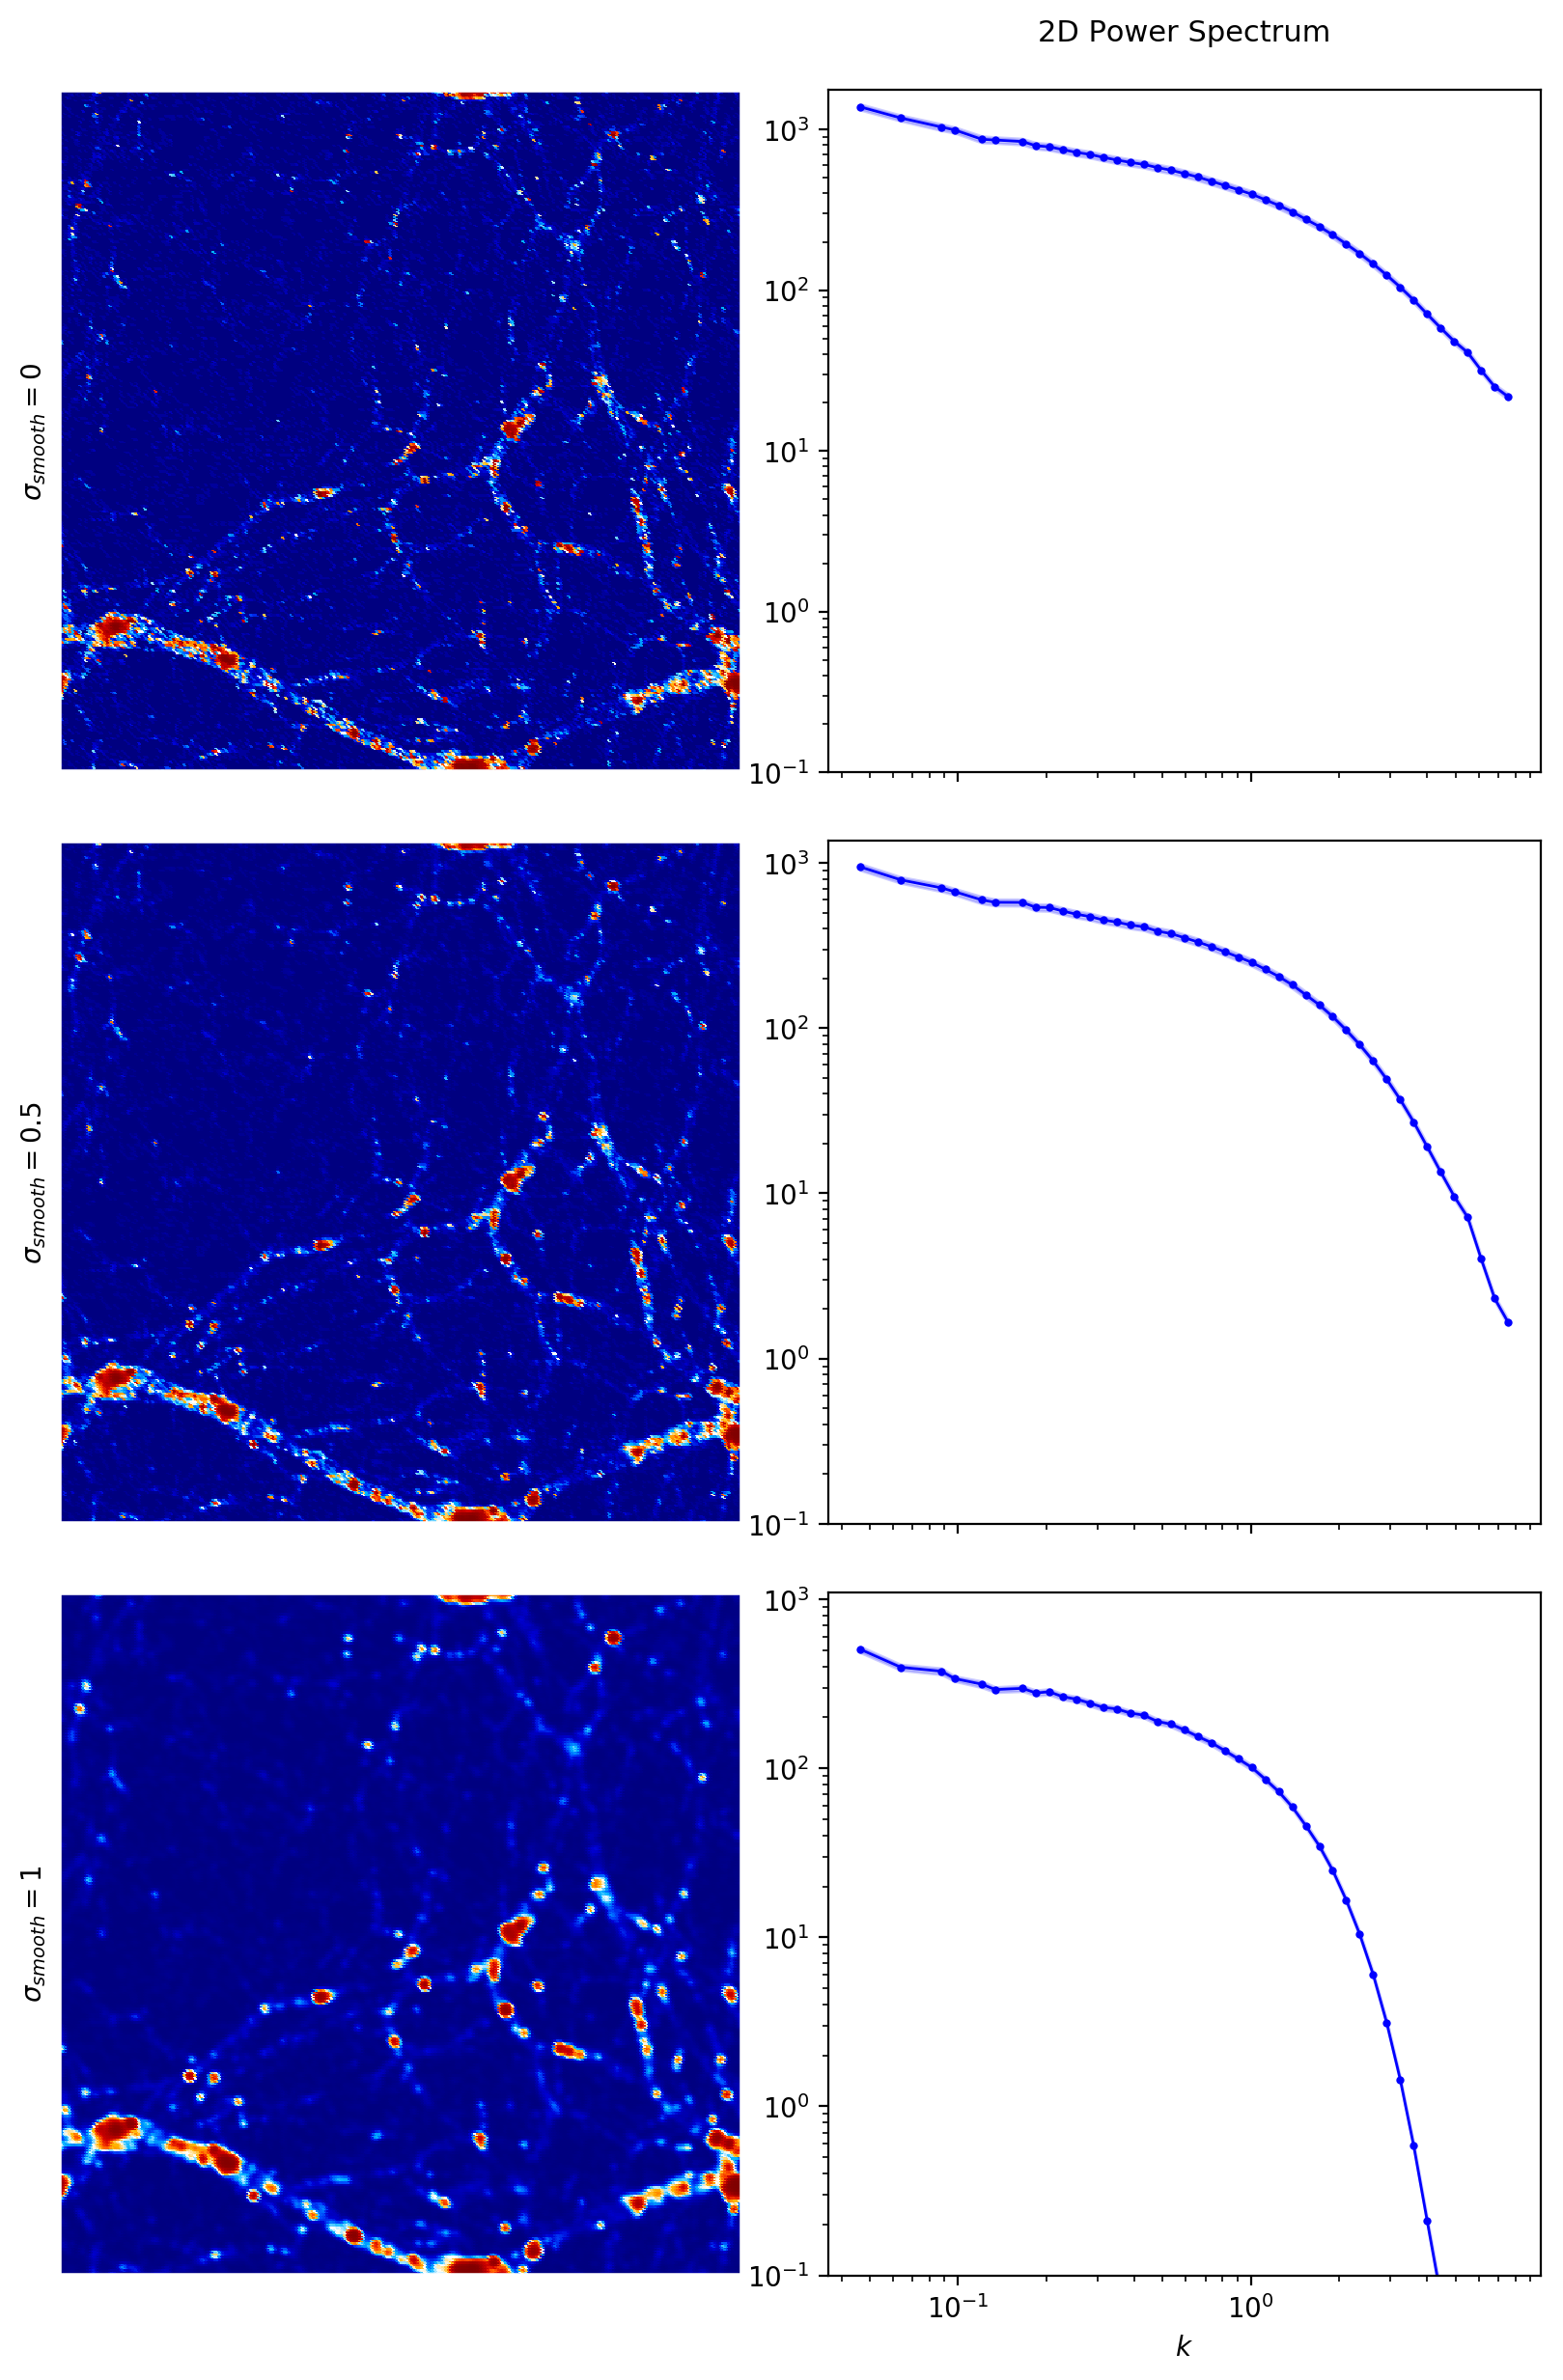

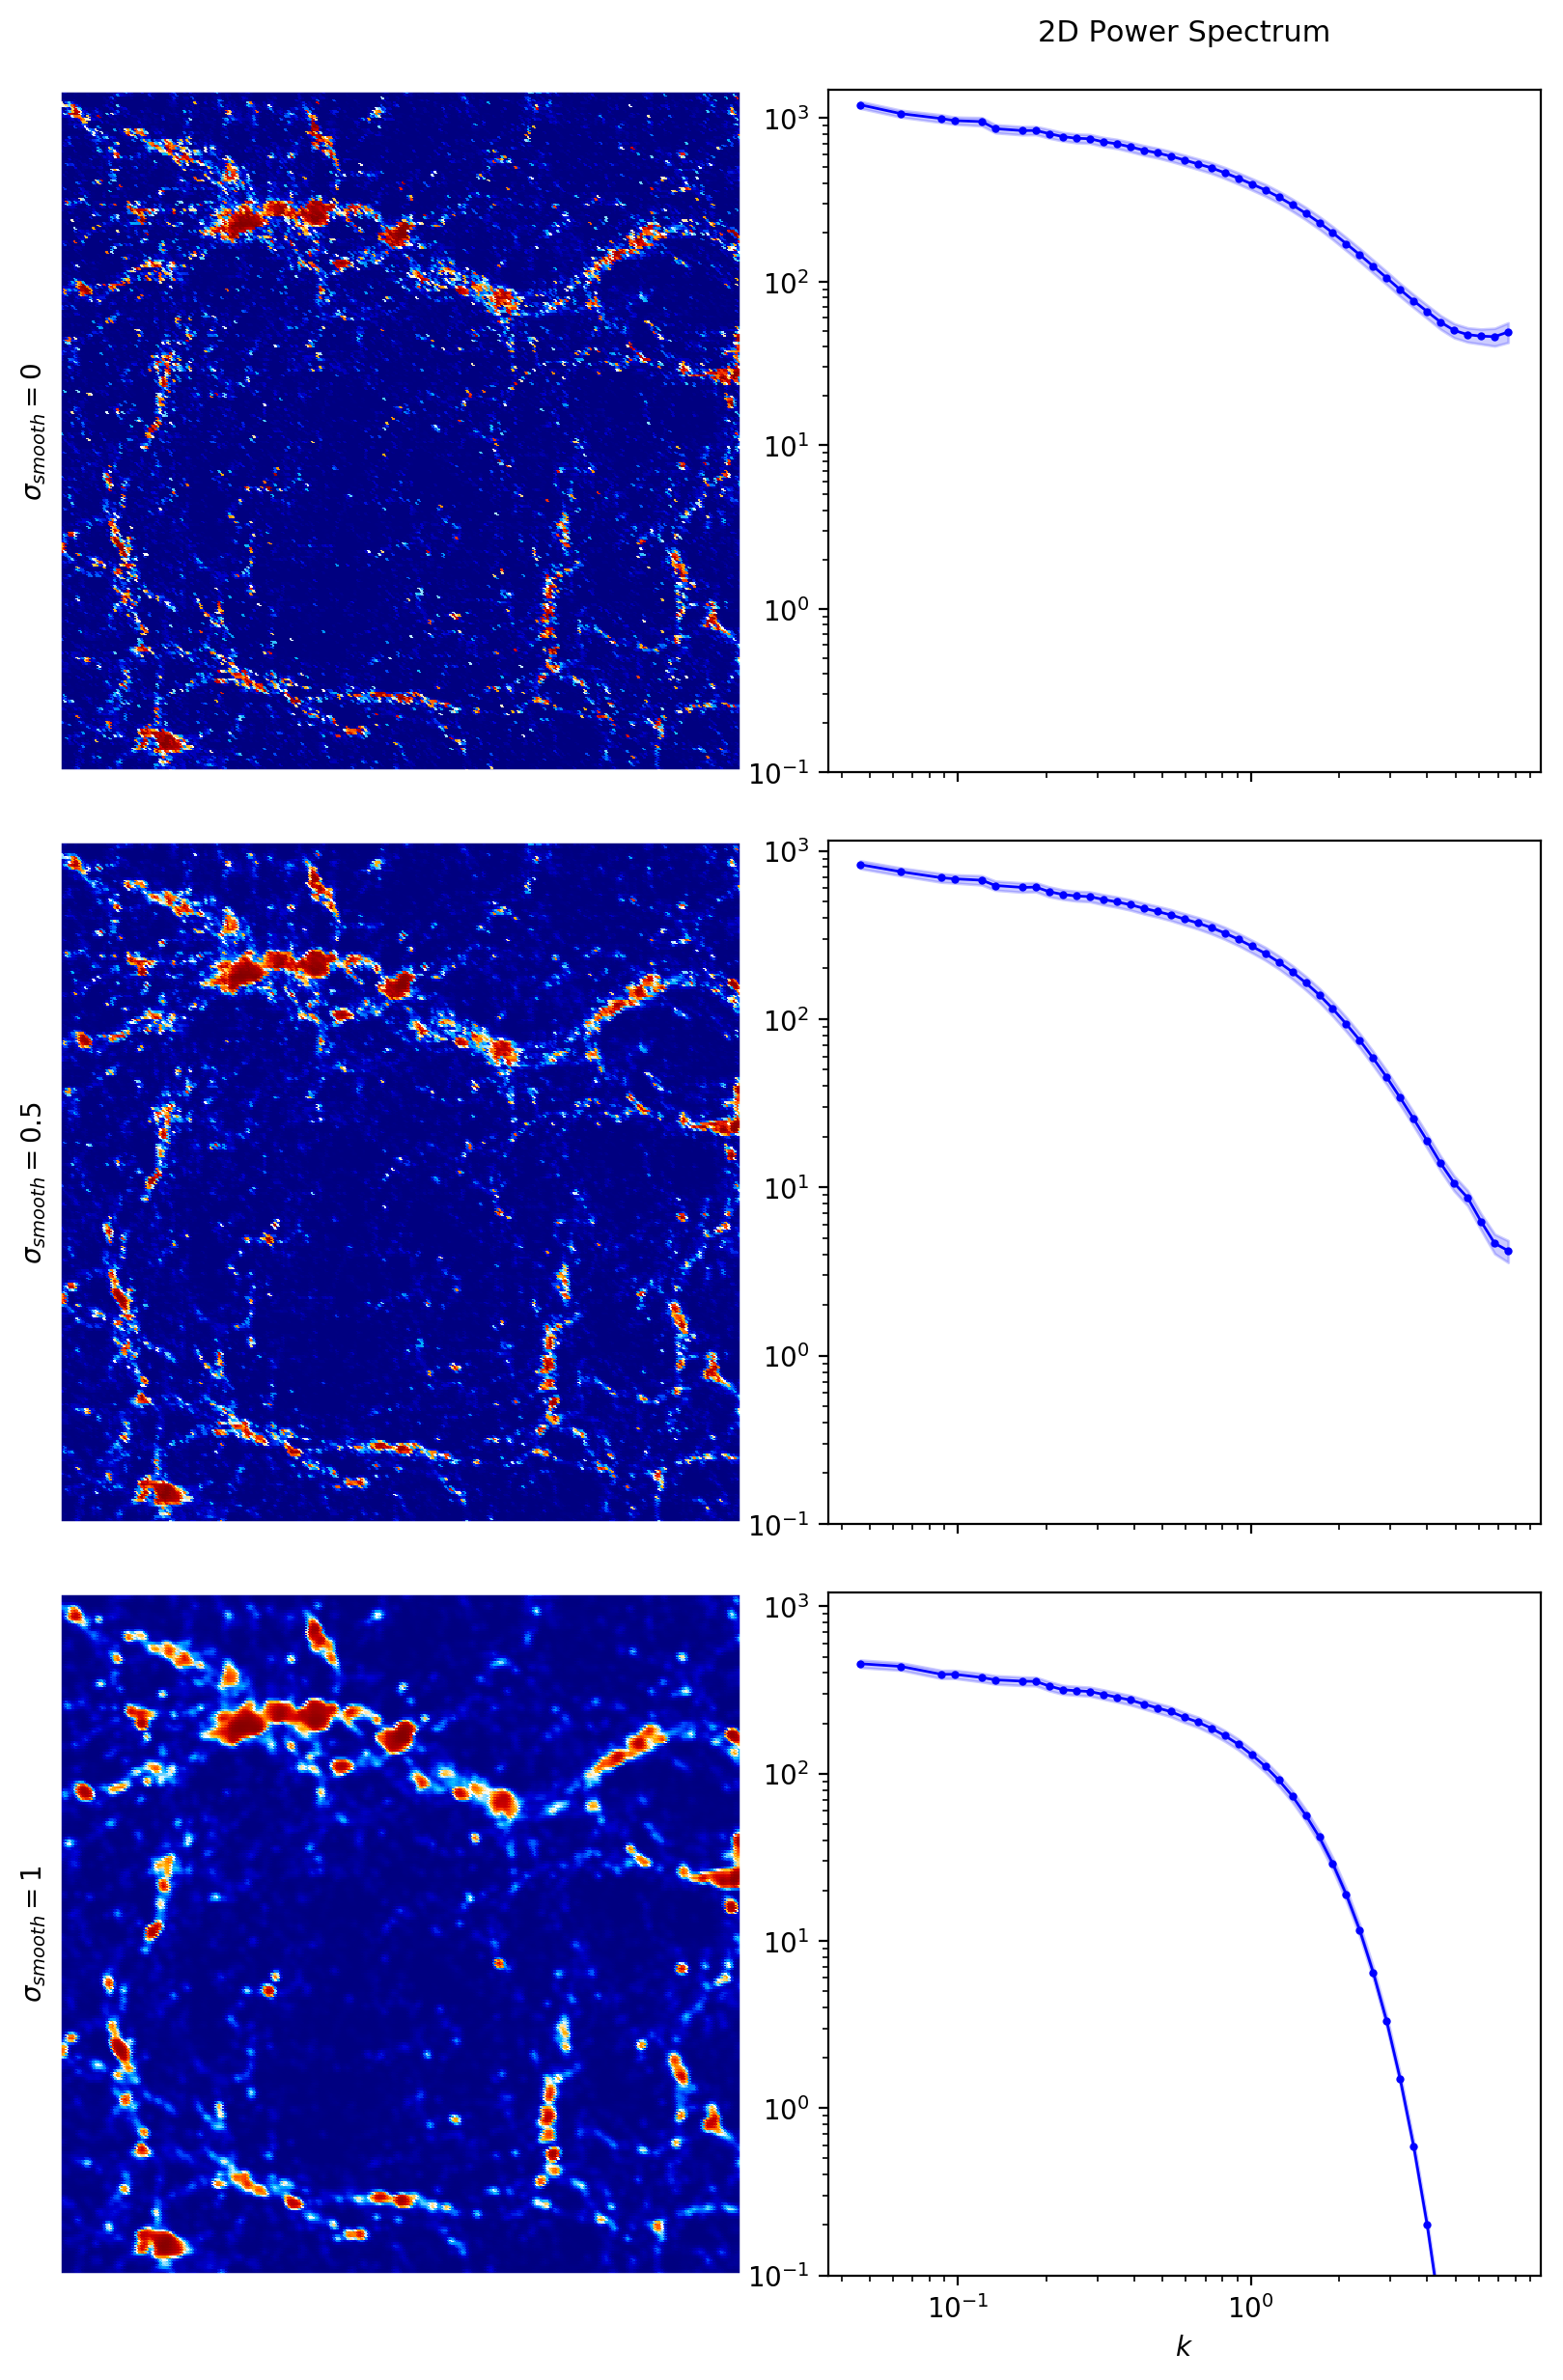

In [250]:

sigma_smooth = [0,0.5,1]
plot.plot_images_psd(real_sample_raw,'' , sigma_smooth = sigma_smooth)
plot.plot_images_psd(gen_sample_raw,'' , sigma_smooth = sigma_smooth)